In [1]:
from fastbook import *

In [3]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label,
        item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize), Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(path,bs=64)

In [4]:
dls = get_data(URLs.IMAGENETTE_160, 160,128)

In [5]:
def get_learner(**kwargs):
    return cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy, **kwargs).to_fp16()

In [6]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.428034,2.632971,0.243567,01:23
1,1.946409,1.704728,0.465987,01:24
2,1.475512,1.294649,0.579873,01:24


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.737800812406931e-05)

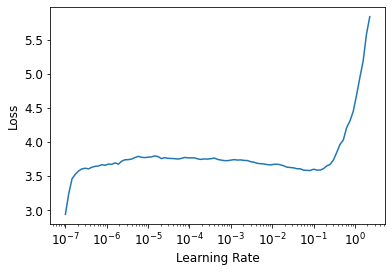

In [7]:
learn = get_learner(opt_func=SGD)
learn.lr_find()

In [8]:
learn.fit_one_cycle(3, 5e-2, moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,2.727779,1.952568,0.306242,01:20
1,2.122790,1.682274,0.457580,01:21
2,1.793189,1.548779,0.509554,01:21


In [13]:
def sgd_cb(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)

In [14]:
opt_func = partial(Optimizer, cbs=[sgd_cb])
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3,5e-2,moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,2.731997,2.291032,0.253503,01:21
1,1.932604,1.825926,0.412229,01:21
2,1.574288,1.350551,0.555414,01:21


In [15]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None:
        grad_avg = torch.zeros_like(p.grad.data)
    
    return {
        'grad_avg':grad_avg*mom + p.grad.data
    }

In [16]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)

In [17]:
opt_func = partial(Optimizer, cbs=[average_grad, momentum_step], mom=0.9)

In [18]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3,5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.414249,2.244000,0.261911,01:22
1,3.190529,3.313373,0.272102,01:22
2,2.572627,2.161093,0.338599,01:22


In [39]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None:
        sqr_avg = torch.zeros_like(p.grad.data)
    return {
            'sqr_avg': sqr_mom * sqr_avg + (1 - sqr_mom) * p.grad.data**2
        }

In [40]:
def rms_prop_step(p, lr, sqr_avg,eps,grad_avg=None,**kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.add_(-lr*p.grad/denom)
    
opt_func = partial(Optimizer, cbs=[average_sqr_grad, rms_prop_step], sqr_mom=0.99, eps=1e-7)
    

In [41]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.441633,2.005192,0.369682,01:24
1,1.739607,3.884793,0.245860,01:24
2,1.446889,1.213340,0.600764,01:24
